In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [2]:
df = pd.read_csv('diamonds_train.csv')

In [3]:
# profile = ProfileReport(df)
# profile.to_file('diamonds_train_profile.html')

# Preço de Diamantes
## Análise Exploratória 

In [4]:
df.price.describe()

count    48940.000000
mean      3934.409644
std       3989.333861
min        326.000000
25%        949.000000
50%       2401.000000
75%       5331.250000
max      18823.000000
Name: price, dtype: float64

Invariavelmente, ou seja, sem considerar nenhuma outra variável, eu poderia dizer que todo e qualquer novo diamante que eu observo custa R$ 3934,40 (média). Isso faria sentido? Se as demais variáveis não fossem responsáveis por mudanças no dataset, sim, poderia fazer sentido. Se independentemente de tamanho, cor, pureza, não houvesse mudança de preço, sim, poderia fazer sentido simplesmente pegar uma média. Mas é isso que acontece?

Vamos analisar a variável `carat (quialtes)` e observar o quanto o peso impacta no valor final de um diamante.

### 1. Carat

In [5]:
df.corr()['price'].sort_values(ascending=False)

price    1.000000
carat    0.922186
x        0.885019
y        0.864059
z        0.860247
table    0.127832
depth   -0.012037
Name: price, dtype: float64

Existe uma alta correlação linear entre `price` e `carat` (0.92). Vamos utilizar o carat para iniciar nossos estudos sobre os motivos pelos quais um diamante varia de preço.

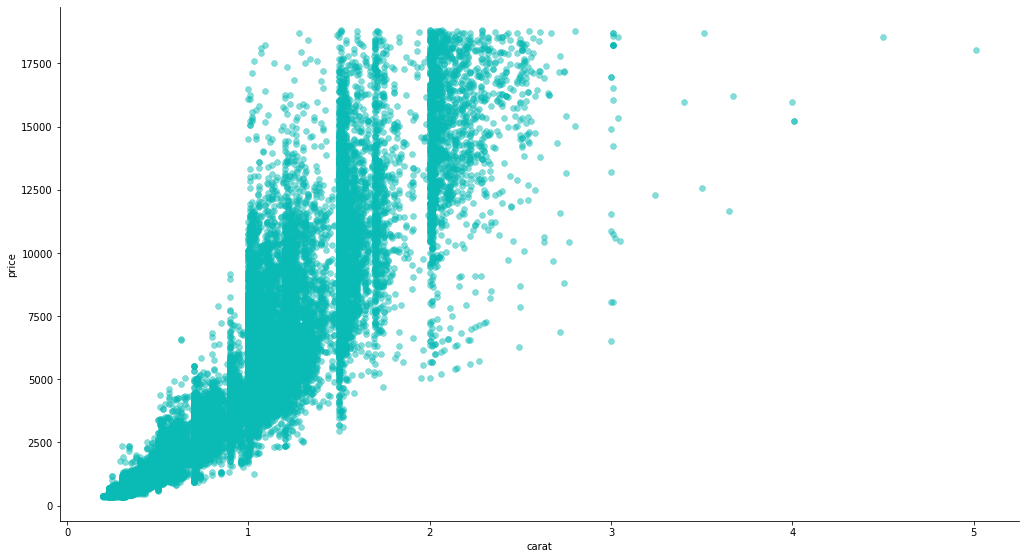

In [6]:
%matplotlib inline
plot = sns.relplot(data=df, y='price', x='carat', edgecolor=None, alpha=0.5, color='#0ABAB5')
plot.fig.set_size_inches(16,8)

Interessante observar que para números cheios em `carat` (1, 1.5, 1.75) temos maiores concentrações de observações, formando-se faixas de valores. Observamos também pela imagem abaixo que até 1 quilate temos uma menor dispersão de valores comparado a quando passamos do valor 1.

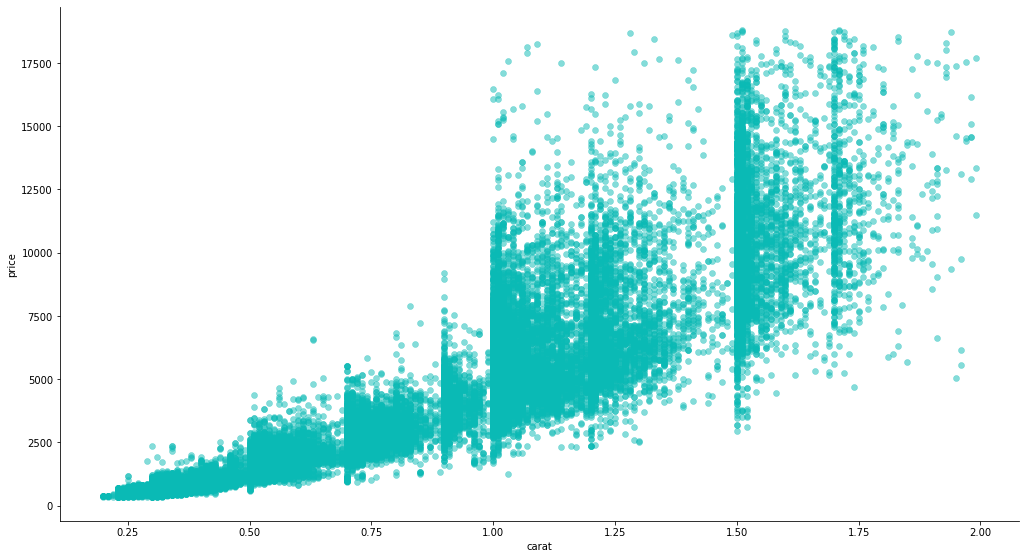

In [7]:
%matplotlib inline
plot = sns.relplot(data=df[df.carat<2], y='price', x='carat', edgecolor=None, alpha=0.5, color='#0ABAB5')
plot.fig.set_size_inches(16,8)

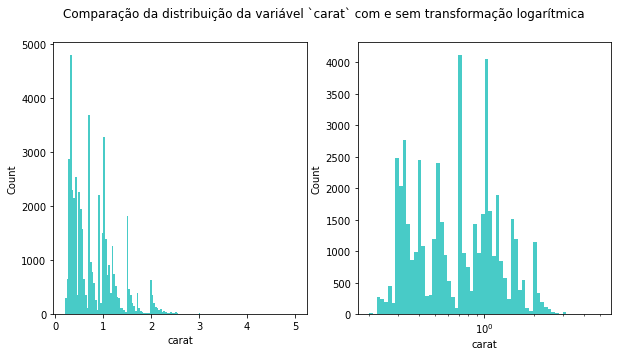

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=df, x='carat', ax=ax[0], color='#0ABAB5', edgecolor=None)
sns.histplot(data=df, x='carat', ax=ax[1], log_scale=10, color='#0ABAB5', edgecolor=None)

fig.suptitle('Comparação da distribuição da variável `carat` com e sem transformação logarítmica');

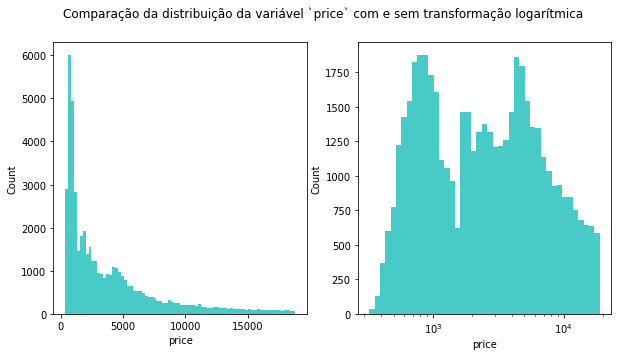

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=df, x='price', ax=ax[0], color='#0ABAB5', edgecolor=None)
sns.histplot(data=df, x='price', ax=ax[1], log_scale=10, color='#0ABAB5', edgecolor=None)

fig.suptitle('Comparação da distribuição da variável `price` com e sem transformação logarítmica');

Tanto `price` quanto `carat` apresentam um alto **right skewness**, portanto, fez sentido aplicar uma transformação logarítima de modo que os altos valores tenham um menor impacto na distribuição. Visualmente falando, a distribuição não se torna uma distribuição normal, porém o right skewness é minimizado e, assim, conseguimos observar uma relação linear onde antes tínhamos uma relação exponencial.

Vamos trabalhar com as duas variáveis nessa escala, e depois retornaremos os valores para a escala original.

In [10]:
# df['carat_log'] = boxcox(df.carat)[0]
# df['price_log'], lambda_price = boxcox(df.price)
df['carat_log'] = np.log(df.carat)
df['price_log'] = np.log(df.price)

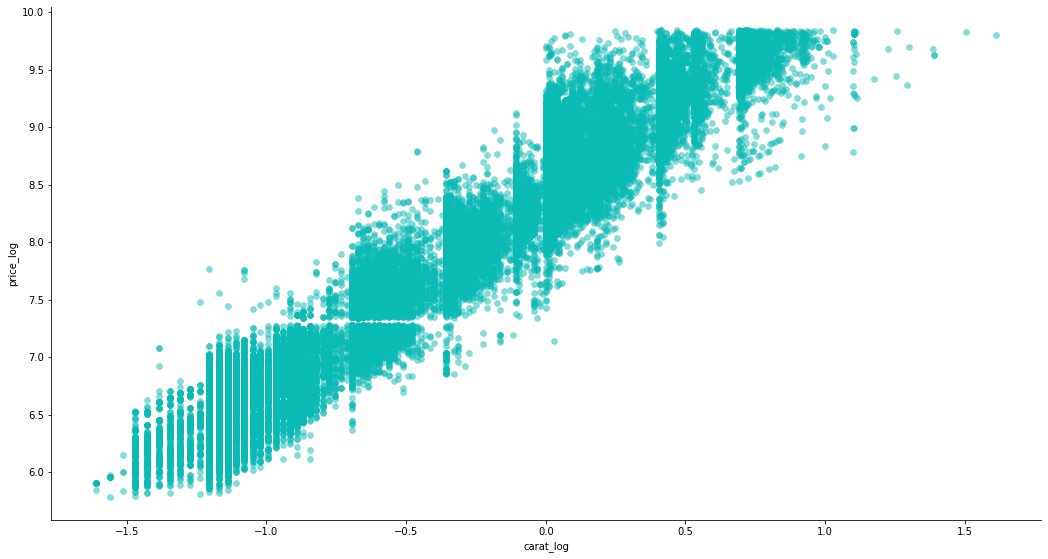

In [11]:
%matplotlib inline
plot = sns.relplot(data=df, y='price_log', x='carat_log', edgecolor=None, alpha=0.5, color='#0ABAB5')
plot.fig.set_size_inches(16,8)

Observamos agora uma relação linear entre as variáveis `price_log` e `carat_log`

## Um peso em quilates maior é melhor?
O peso em quilates, por si só, não determina o valor de um diamante. Por exemplo, **duas pedras de um quilate podem variar muito em valor considerando sua lapidação, pureza e cor**. Assim, fica evidente que _diamantes grandes de qualidade inigualável são raros_. Isso fica claro ao observarmos o scatterplot acima. Para um mesmo valor em `carat_log` temos valores distintos de preços.

Como um diamante é avaliado? (4 C's)
1. `carat` (peso): 1 quilate -> 0,20 g
1. `cut` (lapidação)
1. `clarity` (pureza)
1. `color` (cor)

https://www.tiffany.com.br/engagement/the-tiffany-guide-to-diamonds/

### 2. Cut
Se um diamante tem uma lapidação ruim, ele parecerá opaco mesmo se tiver classificações de cor e pureza altas. Se um diamante tem uma boa lapidação, ele refletirá e refratará a luz, produzindo brilho máximo.

In [12]:
cut_values = {
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Ideal': 4,
    'Premium': 5
}
df['cut_value'] = df.cut.map(lambda x: cut_values[x])

In [13]:
print('Percentual acumulado para a variável `cut_value`')
df.cut_value.value_counts(normalize=True).sort_index(ascending=False).cumsum()*100

Percentual acumulado para a variável `cut_value`


5     25.555783
4     65.621169
3     87.938292
2     97.016755
1    100.000000
Name: cut_value, dtype: float64

**65,62% dos nossos diamantes encontram-se nas categorias de lapidação Ideal e Premium**. Importante observar também que não temos nenhum diamante dentro da categoria Ruim. Quando observamos no box-plot abaixo a variação de preços através dessas categorias, não notamos diferenças nas medianas dos logs dos preços, mas talvez isto ocorra pois esse é um fator realmente relevante quando estamos controlando também variáveis como `carat`, `color` e `clarity`.

<AxesSubplot:xlabel='cut_value', ylabel='price_log'>

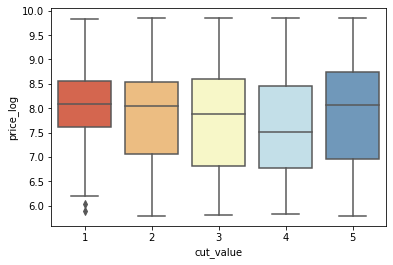

In [14]:
sns.boxplot(data=df, x='cut_value', y='price_log', color='#0ABAB5', palette='RdYlBu')

Além disso, como observamos no scatter-plot abaixo, o fato de 65% dos nossos dados encontrarem-se nas categorias 5 e 4 de lapidação torna difícil visualizar o efeito de categorias inferiores nos preços.

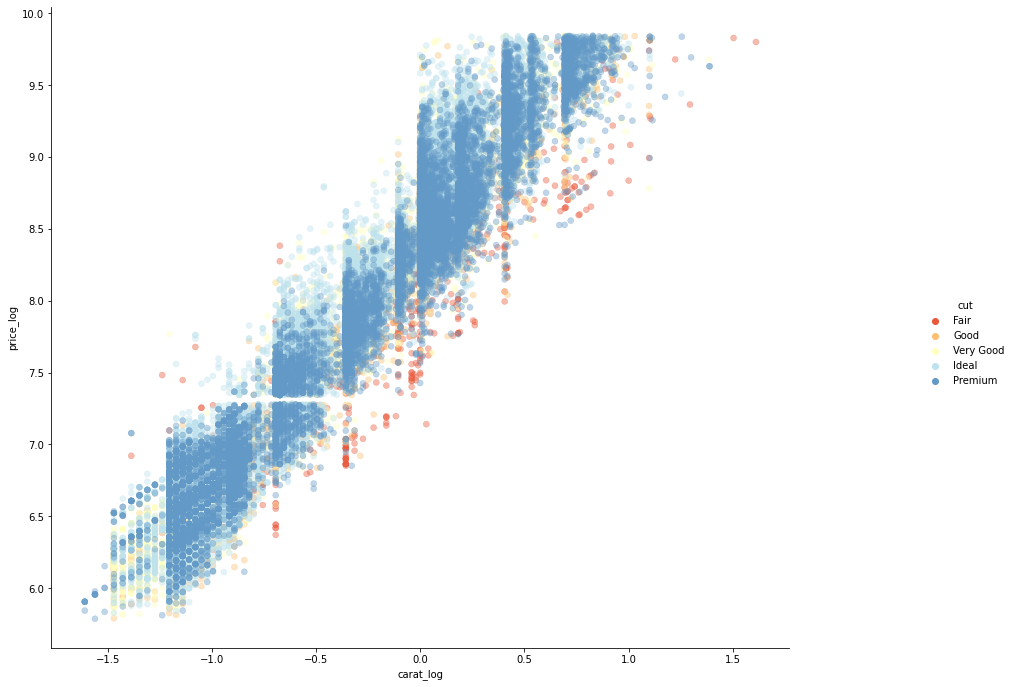

In [15]:
%matplotlib inline
plot = sns.relplot(data=df.sort_values(by='cut_value'), 
                   y='price_log', 
                   x='carat_log', 
                   edgecolor=None, 
                   alpha=0.4, 
                   hue='cut', 
                   palette='RdYlBu')
plot.fig.set_size_inches(15,10)

Para uma mesma categoria, controlando algumas variáveis, observamos que os poucos pontos que caem na categoria `1. Fair` acabam tendo uma redução considerável na mediana do preço.

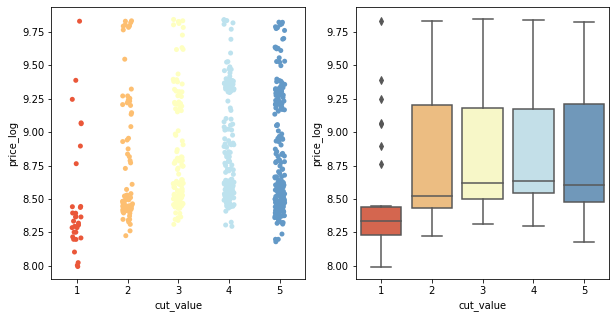

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

data=df[(df.carat_log>=0.0)&(df.carat_log<1.5)&(df.color=='G')&(df.clarity=='SI1')].copy()

sns.stripplot(data=data,
           x='cut_value', y='price_log', palette='RdYlBu', ax=ax1);

sns.boxplot(data=data,
           x='cut_value', y='price_log', palette='RdYlBu', ax=ax2);

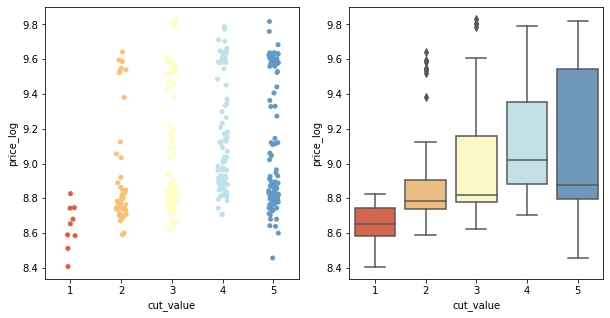

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

data=df[(df.carat_log>=0.0)&(df.carat_log<1.5)&(df.color=='E')&(df.clarity=='VS2')].copy()

sns.stripplot(data=data,
           x='cut_value', y='price_log', palette='RdYlBu', ax=ax1);

sns.boxplot(data=data,
           x='cut_value', y='price_log', palette='RdYlBu', ax=ax2);

### 3. Pureza

![alt text](https://i0.wp.com/luxejewellery.ca/wp-content/uploads/2016/11/diamond-central-clarity-grade-chart.jpg)

In [18]:
clarity_values = {
    'IF':10,
    'VVS1':9,
    'VVS2':8,
    'VS1':7,
    'VS2':6,
    'SI1':5,
    'SI2':4,
    'SI3':3,
    'I1':2,
    'I2':1,
    'I3':0,
}
df['clarity_value'] = df.clarity.map(lambda x: clarity_values[x])

In [19]:
df.clarity_value.value_counts().sort_index()

2       658
4      8307
5     11832
6     11125
7      7449
8      4635
9      3321
10     1613
Name: clarity_value, dtype: int64

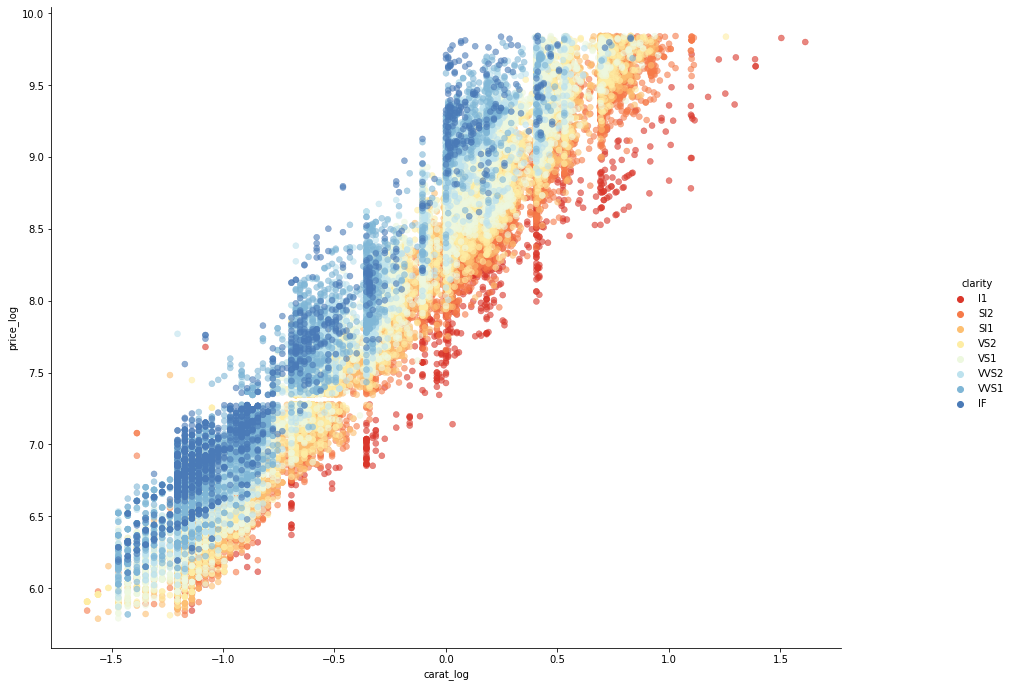

In [20]:
import matplotlib.pyplot as plt

plot = sns.relplot(data=df.sort_values('clarity_value'), y='price_log', x='carat_log', hue='clarity', edgecolor=None, palette='RdYlBu', alpha=0.6) # Pureza 
plot.fig.set_size_inches(15,10)

Observa-se que, para uma mesma faixa de quilate, temos um padrão para a variável clarity, onde valores mais altos de preço pertencem à categria `IF` (internally flawless), e valores mais baixos de preço pertencem à categoria `I1` (included).

### 4. Cor


![alt text](https://www.pricescope.com/wp-content/uploads/2020/12/pricescope-education-103.1-diamond-color-chart-ss-1024x576.jpg)

A cor é a segunda característica mais importante dos 4Cs, porque a classificação da cor afeta diretamente a aparência da pedra. Diamantes com classificação de cor ruim podem parecer ligeiramente amarelos em vez de apresentarem o desejado branco brilhante.

In [21]:
color_values = {'D':6, 'E':5, 'F':4, 'G':3, 'H':2, 'I':1, 'J':0}

In [22]:
df.color.value_counts(normalize=True).cumsum()

G    0.210196
E    0.391418
F    0.568226
H    0.722333
D    0.848202
I    0.948100
J    1.000000
Name: color, dtype: float64

In [23]:
df['color_value'] = df.color.map(lambda x: color_values[x])

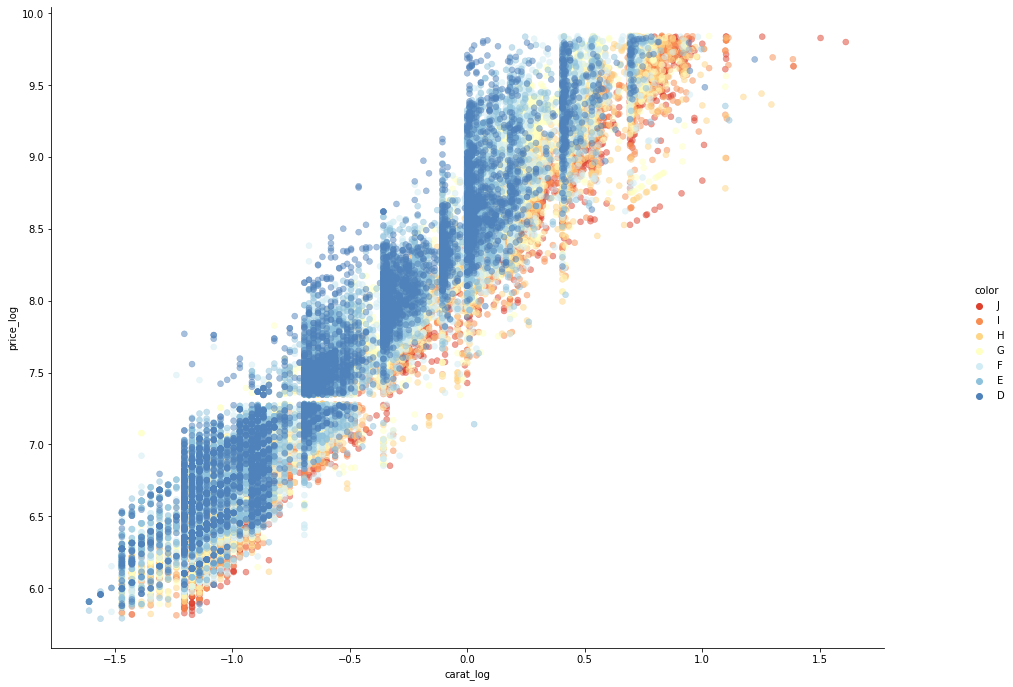

In [24]:
import matplotlib.pyplot as plt

plot = sns.relplot(data=df.sort_values('color_value'), y='price_log', x='carat_log', hue='color', edgecolor=None, palette='RdYlBu', alpha=0.5) # Pureza 
plot.fig.set_size_inches(15,10)

Para a variável `color` não notamos um padrão tão claro quanto para a variável `clarity`. Vamos isolar essa segunda variável de modo que verifiquemos se existe algum padrão mais óbvio para a variável `color`.

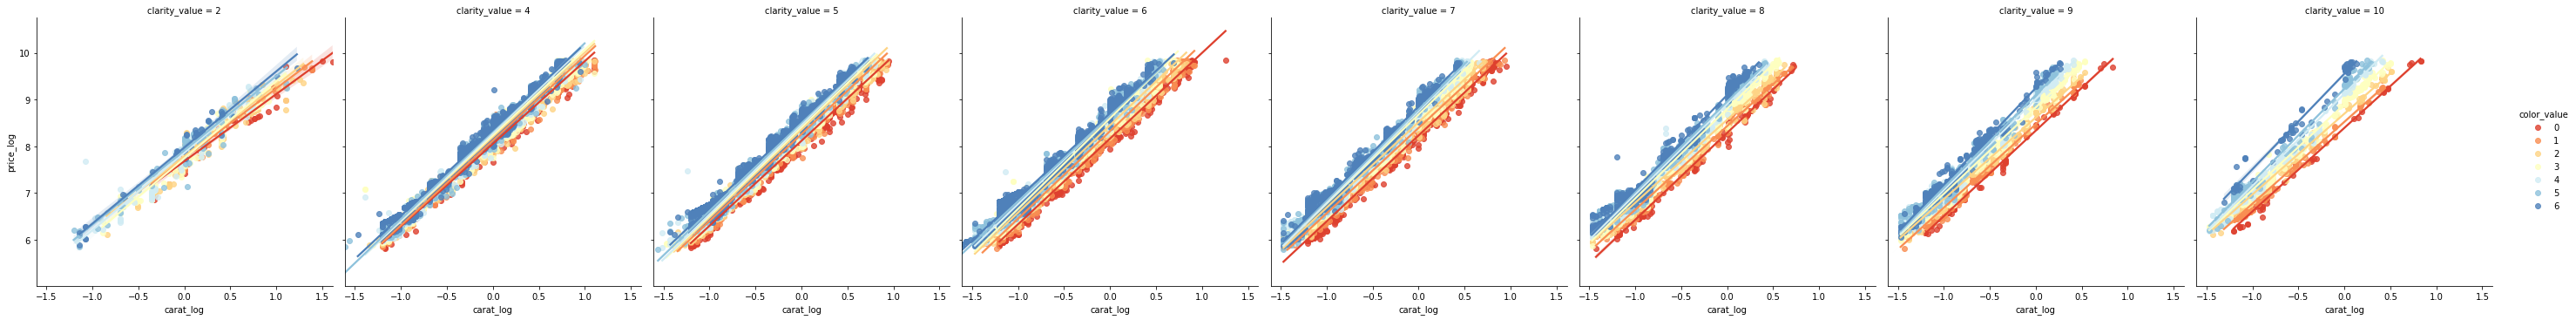

In [25]:
sns.lmplot(data=df.sort_values(by=['clarity_value', 'color_value']), 
           y='price_log', 
           x='carat_log', 
           col='clarity_value',
           hue='color_value',
           palette='RdYlBu')

Com as quebras por `clarity` voltamos a enxergar um padrão, onde desta vez para uma cor próximo à D (valor 6) temos alta nos valores dos diamantes, e para valores mais baixos obtemos um valor menor para os diamantes.

-------

## Regressão Linear: Criação do Modelo

In [26]:
from sklearn.linear_model import LinearRegression

#### Baseline
* variáveis independentes: `carat`, `color_value`, `clarity_value`
* variável dependente: `price`

In [27]:
X = df[['clarity_value', 'color_value', 'carat']]
y = df.price

model = LinearRegression()
model.fit(X, y)

np.sqrt(mean_squared_error(y, model.predict(X)))

1228.5851052761843

#### 1a estratégia
* variáveis independentes: `carat_log`, `color_value`, `clarity_value`
* variável dependente: `price_log`

In [28]:
X = df[['clarity_value', 'color_value', 'carat_log']]
y = df.price_log

model = LinearRegression()
model.fit(X, y)

np.sqrt(mean_squared_error(df.price, np.exp(model.predict(X))))
# np.sqrt(mean_squared_error(df.price, inv_boxcox(model.predict(X), lambda_price)))

929.6715983458793

In [29]:
model.intercept_

7.503091942147989

In [30]:
model.coef_

array([0.125724  , 0.07774451, 1.87342827])

#### 2a estratégia
* transformação `z_score` para as variáveis independentes
* variáveis independentes: `carat_log`, `color_value`, `clarity_value`
* variável dependente: `price_log`

In [74]:
X = df[['clarity_value', 'color_value', 'carat_log']]
y = df.price_log

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [76]:
X_standarized = scaler.transform(X)

model = LinearRegression()

model.fit(X_standarized, y)

LinearRegression()

In [78]:
np.sqrt(mean_squared_error(df.price, np.exp(model.predict(X_standarized))))
# np.sqrt(mean_squared_error(df.price, inv_boxcox(model.predict(X_standarized), lambda_price))) 910

929.6715983458921

In [35]:
model.intercept_

7.787206124968811

In [36]:
model.coef_

array([0.21049592, 0.13215324, 1.09580796])

#### 3a estratégia
* variáveis independentes: `carat_log`, `color_value`, `clarity_value`, `cut_value`
* variável dependente: `price_log`

In [37]:
X = df[['clarity_value', 'color_value', 'cut_value', 'carat_log']]
y = df.price_log

model = LinearRegression()
model.fit(X, y)

# np.sqrt(mean_squared_error(df.price, inv_boxcox(model.predict(X), lambda_price))) 907
np.sqrt(mean_squared_error(df.price, np.exp(model.predict(X))))

923.5466651224988

#### 4a estratégia
* variáveis independentes: `carat_log`, `color_value`, `clarity_value`, `cut_Fair`
* variável dependente: `price_log`

In [38]:
df['cut_Fair'] = pd.get_dummies(df[['cut']])['cut_Fair']

X = df[['clarity_value', 'color_value', 'carat_log', 'cut_Fair']]
y = df.price_log

model = LinearRegression()
model.fit(X, y)

# np.sqrt(mean_squared_error(df.price, inv_boxcox(model.predict(X), lambda_price))) 886.3417042898633
np.sqrt(mean_squared_error(df.price, np.exp(model.predict(X))))

904.8836777349078

#### 5a estratégia

In [39]:
model_results = dict()

for clarity in df.clarity.unique():
    X = df.loc[df.clarity==clarity, ['color_value', 'carat_log', 'cut_Fair']].copy()
    y = df.loc[df.clarity==clarity, ['price_log']].copy()
    
    model = LinearRegression()
    model.fit(X,y)
    
    # df.loc[df.clarity==clarity, 'price_predicted'] = inv_boxcox(model.predict(X), lambda_price) 763
    df.loc[df.clarity==clarity, 'price_predicted'] = np.exp(model.predict(X))
    
    model_results[clarity] = model

In [40]:
np.sqrt(mean_squared_error(df.price, df.price_predicted))

769.7979086356726

In [41]:
model_results

{'SI1': LinearRegression(),
 'VS1': LinearRegression(),
 'VS2': LinearRegression(),
 'SI2': LinearRegression(),
 'VVS2': LinearRegression(),
 'VVS1': LinearRegression(),
 'I1': LinearRegression(),
 'IF': LinearRegression()}

## Regressão Linear: Aplicando o Modelo
Da 5a estratégia

In [42]:
df_test = pd.read_csv('diamonds_test.csv')

In [43]:
df_test['color_value'] = df_test.color.map(lambda x: color_values[x])
df_test['carat_log'] = np.log(df_test.carat)
df_test['cut_Fair'] = pd.get_dummies(df_test[['cut']])['cut_Fair']

In [44]:
for clarity in df_test.clarity.unique():
    X = df_test.loc[df_test.clarity==clarity, ['color_value', 'carat_log', 'cut_Fair']].copy()
    model = model_results[clarity]
    # df_test.loc[df_test.clarity==clarity, 'price_predicted'] = inv_boxcox(model.predict(X), lambda_price)
    df_test.loc[df_test.clarity==clarity, 'price_predicted'] = np.exp(model.predict(X))

In [45]:
df_test.drop(['color_value', 'carat_log', 'cut_Fair'], axis=1, inplace=True)

In [46]:
df_test.to_csv('price_predicted.csv') # 781, 848

In [72]:
df_test.price_predicted.describe()

count     5000.000000
mean      3864.963075
std       3889.754215
min        269.600216
25%        975.124850
50%       2469.632159
75%       5188.608886
max      26125.016848
Name: price_predicted, dtype: float64

In [50]:
# 'color_value', 'carat_log', 'cut_Fair'
for value, model in model_results.items():
    print(value, model.coef_, model.intercept_)

SI1 [[ 0.06280077  1.88327569 -0.11553579]] [8.20306319]
VS1 [[ 0.08715787  1.89077251 -0.14410747]] [8.35684312]
VS2 [[ 0.08912703  1.87938081 -0.10573373]] [8.26517878]
SI2 [[ 0.04761762  1.84460127 -0.13626088]] [8.09139431]
VVS2 [[ 0.10042857  1.90478321 -0.12645208]] [8.45677356]
VVS1 [[ 0.10843815  1.88217318 -0.08656346]] [8.49646532]
I1 [[ 0.04018879  1.58333942 -0.22557338]] [7.74584498]
IF [[ 0.14178079  1.86775134 -0.17933592]] [8.49326576]


### Aplicação: Descrever

Quero parar de investir em lapidadores. Para isso, quero estimar qual poderia ser o impacto de alterar essa variável, _ceteris paribus_.

In [79]:
clarity = 'SI1'
color_value = 3 
carat_log = -0.39

In [60]:
model_results[clarity].coef_

array([[ 0.06280077,  1.88327569, -0.11553579]])

In [67]:
model_results[clarity].intercept_

array([8.20306319])

In [82]:
ceteris_paribus = (0.06280077*color_value)+(1.88327569*carat_log)

In [83]:
np.exp(ceteris_paribus+(-0.11553579*1)+8.20306319)

1884.5647868179697

In [85]:
np.exp(ceteris_paribus+(-0.11553579*0)+8.20306319)

2115.3762695886976

In [70]:
2115.3762695886976-1884.5647868179697

230.81148277072793